In [396]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os

## <u>Import Datasets and Train Test Split<u>

In [397]:
df = pd.read_csv('/Users/zachwayne/Downloads/Australia.csv')
withTags = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/feed_into_pipeline_data_withTags.csv'))
summaries = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/GlobalOriginalsWithSummary.csv'))[['combined_title', 'summary']]
people_rankings = pd.read_csv(os.path.relpath('/Users/zachwayne/Dropbox (MIT)/Netflix - Seize the Data/showsWithPrinicpalRankings.csv'))[['combined_title', 'director_rank', 'writer_rank', 'actor_rank']]
# keep only tconst and cumulative_weeks_in_top_10
df = df[['tconst', 'cumulative_weeks_in_top_10']]
df = df.merge(withTags, on='tconst', how='left')

df['release_date'] = pd.to_datetime(df['release_date'])
df = df[df['release_date'] >= '6/1/2021']

# merge all 3 datasets
df = df.merge(summaries, on='combined_title', how='left')
df = df.merge(people_rankings, on='combined_title', how='left')
df.drop_duplicates(inplace=True)



df['is_top10'] = df['cumulative_weeks_in_top_10'].apply(lambda x: 1 if x > 0 else 0)
del df['cumulative_weeks_in_top_10']

# split into tv_shows only and sort by combined_title
tv_shows = df[df['is_tv_show']==True]

In [398]:
# remove tv shows that have seasons > 24
tv_shows = tv_shows[tv_shows['season'] < 24]
tv_shows = tv_shows.sort_values(by='combined_title')
tv_shows

# drop combined_title, release_date, lower_title, is_tv_show, tconst
tv_shows = tv_shows.drop(['combined_title', 'release_date', 'lower_title', 'is_tv_show', 'tconst'], axis=1)
tv_shows.shape

(653, 21)

In [399]:
# train test split with stratified sampling
from sklearn.model_selection import train_test_split

# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(tv_shows.drop('is_top10', axis=1), tv_shows['is_top10'], test_size=0.2, random_state=42, stratify=tv_shows['is_top10'])

# # split into training and validation sets
# tvshows_X_train, tvshows_X_val, tvshows_y_train, tvshows_y_val = train_test_split(tvshows_X_train, tvshows_y_train, test_size=0.2, random_state=42, stratify=tvshows_y_train)

In [400]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Normalizer

In [401]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from nltk.stem import SnowballStemmer
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]
        
class StemTokenizer(object):
    def __init__(self):
        self.stemmer = SnowballStemmer('english')
    def __call__(self, articles):
        return [self.stemmer.stem(t) for t in word_tokenize(articles)]


tf_vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(),
                       strip_accents = 'unicode',
                       stop_words = 'english',
                       lowercase = True)



In [402]:
from sklearn.feature_extraction import text

custom_stop_words = []
# add lemmatized stop words to stop_words list

for i in text.ENGLISH_STOP_WORDS:
    custom_stop_words.append(SnowballStemmer('english').stem(i))

In [403]:
new_stop_words = text.ENGLISH_STOP_WORDS.union(custom_stop_words)

## <u>Removal of averageRating and numVotes<u>

### <u>XGBoost : Summary (BOW), Stemming<u> (Uncomment and Run) **JOSEPH POR FAVOR**

In [404]:
rankings_pipeline = Pipeline([
    #('imputer', SimpleImputer(strategy='mean')),
    #('imputer', IterativeImputer()),
    ('missingimputer', KNNImputer()),
    ('logger', FunctionTransformer(np.log1p))
])

xgb_transformer = ColumnTransformer(
    [
        ("onehot_titleType",OneHotEncoder(handle_unknown='ignore'), ['titleType']),                 # one-hot encode titleType
        ("onehot_release_year",OneHotEncoder(handle_unknown='ignore'), ['release_year']),           # discrete release year
        ("bagofwords", CountVectorizer(tokenizer=StemTokenizer(), stop_words='english', min_df=0.02), 'summary'),              # One hot encoding
        #("tfidf", TfidfVectorizer(tokenizer=StemTokenizer(), stop_words='english'), 'summary'),                  # TF-IDF
        ("genres_count", CountVectorizer(min_df=0.01), 'genres'),
        #("sentence_transformer", embedder, 'summary'),                                             # hugging face - PCA
        #("imputer", SimpleImputer(strategy='mean'), ['averageRating', 'numVotes', 'runtimeMinutes']),
        ("rankings_pipeline", rankings_pipeline, ['director_rank', 'actor_rank', 'writer_rank']),   # log transform rankings
        ("onehot_v",OneHotEncoder(handle_unknown='ignore'), ['violence']),                          # one-hot encode violence
        ("onehot_n",OneHotEncoder(handle_unknown='ignore'), ['nudity']),                            # one-hot encode nudity
        ("onehot_p",OneHotEncoder(handle_unknown='ignore'), ['profanity']),                         # one-hot encode profanity
        ("onehot_a",OneHotEncoder(handle_unknown='ignore'), ['alcohol']),                           # one-hot encode alcohol
        ("onehot_f",OneHotEncoder(handle_unknown='ignore'), ['frightening']),                       # one-hot encode frightening
        ("onehot_l",OneHotEncoder(min_frequency=0.01, handle_unknown='infrequent_if_exist'), ['language']),        # one-hot encode language
    ],
    remainder='passthrough')

# Recreate pipeline using XGBoost
xgb_pipe = Pipeline(
    steps=[
        ('xgb_transformer', xgb_transformer),
        #('normalizer', Normalizer()),
        ('xgb', XGBClassifier())
    ]
)

xgb_gs_bow_stem_drop = GridSearchCV(
    xgb_pipe,
    param_grid={
        'xgb__max_depth': [3, 5, 7],
        'xgb__learning_rate': [0.01, 0.05, 0.1],
        'xgb__n_estimators': [100, 200],
        'xgb__subsample': [0.8, 0.85, 0.9],
    },
    scoring={"AUC": "roc_auc", "F1": "f1", "Accuracy": "accuracy"},
    refit="AUC",
    cv=5,
    verbose=0,
    n_jobs=-1,
)

In [405]:
# fit xgb_gs_bow_stem_drop model
xgb_gs_bow_stem_drop.fit(X_train.drop(columns=['averageRating', 'numVotes'], axis=1), y_train)

/Users/zachwayne/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:404: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(
/Users/zachwayne/opt/anaconda3/lib/python3.9/site-

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('xgb_transformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehot_titleType',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['titleType']),
                                                                        ('onehot_release_year',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['release_year']),
                                                                        ('bagofwords',
                                                                         CountVectorizer(min_df=0.02,
                                                                                         stop_words='english',
                                                                                         tokenizer=<__m...
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             n_jobs=-1,
             param_grid={'xgb__learning_rate': [0.01, 0.05, 0.1],
                         'xgb__max_depth': [3, 5, 7],
                         'xgb__n_estimators': [100, 200],
                         'xgb__subsample': [0.8, 0.85, 0.9]},
             refit='AUC',
             scoring={'AUC': 'roc_auc', 'Accuracy': 'accuracy', 'F1': 'f1'})

In [406]:
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score

# save best xgb_gs_bow_stem_drop model as a variable
best_xgb_gs_bow_stem_drop = xgb_gs_bow_stem_drop.best_estimator_

# output best score
print(f"XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Best CV Score: {xgb_gs_bow_stem_drop.best_score_:.5f}")

# output auc, f1-score, and accuracy on test set
print(f"XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set AUC: {roc_auc_score(y_test, best_xgb_gs_bow_stem_drop.predict_proba(X_test.drop(['averageRating', 'numVotes'], axis=1))[:,1]):.5f}")
print(f"XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set F1: {f1_score(y_test, best_xgb_gs_bow_stem_drop.predict(X_test.drop(['averageRating', 'numVotes'], axis=1))):.5f}")
print(f"XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set Accuracy: {accuracy_score(y_test, best_xgb_gs_bow_stem_drop.predict(X_test.drop(['averageRating', 'numVotes'], axis=1))):.5f}")

XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Best CV Score: 0.81137
XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set AUC: 0.85005
XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set F1: 0.57143
XGBoost BOW, Stemmed (Dropped Avg. Ratings and No. Votes) Test set Accuracy: 0.90840


In [407]:
def get_feature_names(estimator, numeric_features=['release_year', 'titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank']):
    """Get feature names from a pipeline or column transformer."""
    feature_names = []
    for transformer in estimator.transformers_:
        try:
            if transformer[0] == 'rankings_pipeline':
                feature_names.append(['director_rank', 'actor_rank', 'writer_rank'])
            elif type(transformer[1]) == CountVectorizer:
                feature_names.append(transformer[2] + "_" + transformer[1].get_feature_names_out())
            else:
                feature_names.append(transformer[1].get_feature_names_out())
        except:
            pass
    feature_names = np.concatenate(feature_names)
    unchanged_features = [feature for feature in estimator.feature_names_in_ if feature not in numeric_features]
    feature_names = np.concatenate([feature_names, unchanged_features])
    return feature_names

In [408]:
xgb_gs_bow_drop_feature_names = get_feature_names(best_xgb_gs_bow_stem_drop['xgb_transformer'], ['titleType', 'genres', 'summary', 'nudity', 'violence', 'profanity', 'alcohol', 'frightening', 'language', 'director_rank', 'actor_rank', 'writer_rank'])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


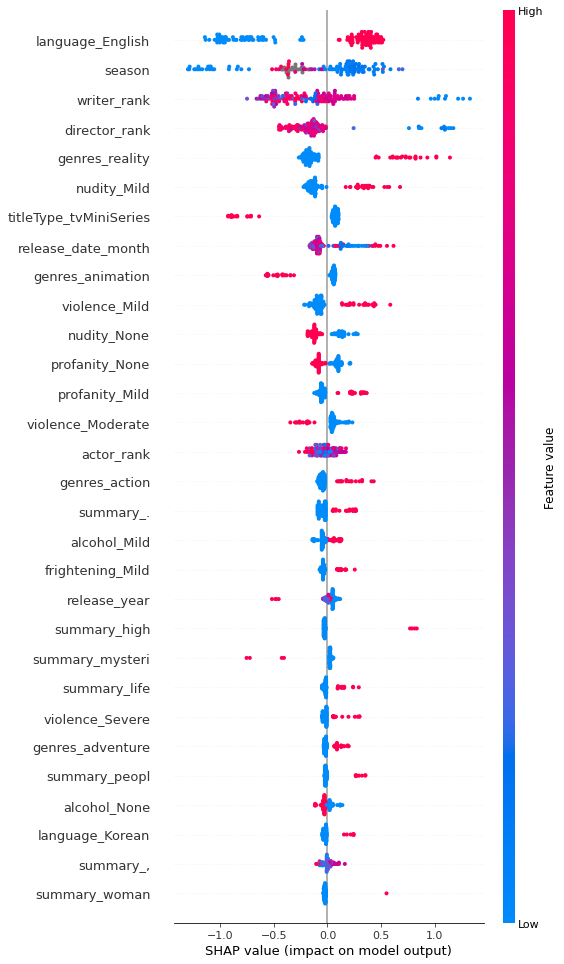

In [409]:
# make shap values
import shap
import xgboost as xgb

transformed_test = best_xgb_gs_bow_stem_drop['xgb_transformer'].transform(X_test.drop(columns=['averageRating', 'numVotes']))
explainer = shap.TreeExplainer(best_xgb_gs_bow_stem_drop['xgb'])
shap_values = explainer.shap_values(xgb.DMatrix(transformed_test, y_test))

# plot shap values
shap.summary_plot(shap_values, pd.DataFrame(transformed_test.todense()), feature_names=xgb_gs_bow_drop_feature_names, max_display=30)

In [410]:
# add shap values to